In [1]:
%load_ext autoreload
% autoreload 2
import model_lib


UsageError: Line magic function `%` not found.


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import shap



/home/vincent/git_repos/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter

import copy

from sklearn.datasets import make_classification
from alipy import ToolBox

import joblib


Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


In [4]:
features = ['Src IP', 'Dst IP','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
def clean_df(df):
    # Remove the space before each feature names
    
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)
    

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    # df.drop(zero_variance_cols, axis = 1, inplace = True)
    # print('zero variance columns', zero_variance_cols, 'dropped')
    # print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    # column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    # ide_cols = []
    # for column_pair in column_pairs:
    #     ide_cols.append(column_pair[1])
    # df.drop(ide_cols, axis = 1, inplace = True)
    # print('columns which have identical values', column_pairs, 'dropped')
    # print('shape after removing identical value columns:', df.shape)
    return df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df



In [5]:
dataset_csv_path = './Dataset/SimulatedCVE/cicflowmeter_cve/'
folder_names = ['dripper/', 'BENIGN/', 'bonesi/']

def read_csv():
    full_df = pd.DataFrame()
    for folder in folder_names:
        csv_file_names = os.listdir("Dataset/SimulatedCVE/cicflowmeter_cve/" + folder)
        complete_paths = []
        for csv_file_name in csv_file_names:
            print(csv_file_name)
            complete_paths.append(os.path.join(dataset_csv_path+folder, csv_file_name))
        df = pd.concat(map(pd.read_csv, complete_paths), 
                                ignore_index = True)
        df = df[features].copy()
        df["Label"] = folder[:-1]
        full_df = pd.concat([full_df, df], axis=0, ignore_index=True)
    cleaned_df = clean_df(full_df)
    return cleaned_df
full_df = read_csv()
full_df["Label"].value_counts()


merged_20240809091803_ISCX.csv
merged_20240809091912_ISCX.csv
merged_20240809091837_ISCX.csv
merged_20240809091950_ISCX.csv
merged_20240809092024_ISCX.csv
final_merged_1.csv
final_merged_2.csv
final_merged.csv
gm_train_data_0.csv
merged_20240813111613_ISCX.csv
dataset shape (404749, 64)
4835 rows dropped
shape after removing nan: (399914, 64)
shape after dropping duplicates: (285043, 64)


Label
BENIGN     140114
dripper    113205
bonesi      31724
Name: count, dtype: int64

In [6]:
import random

random.seed(42)  # Set seed for random operations
np.random.seed(42)  # Set seed for NumPy operations
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [7]:
flow_df = full_df.drop(columns=["Src IP","Dst IP"], inplace=False, axis=1).copy()
label = flow_df['Label']
le = LabelEncoder()
df = flow_df.copy()
df = sample_df(df, 0.05) # Evaluate Small amounts of Malicious Attack

print("Label Count of each attacks after sampling")
df["Label"].value_counts()
df['Label'] = df['Label'].apply(lambda x: 0 if x == "BENIGN" else 1)
print("Binary Label Counts")
df['Label'].value_counts()


Label Count of each attacks after sampling


Label
BENIGN     140114
dripper      5413
bonesi       1593
Name: count, dtype: int64

Binary Label Counts


Label
0    140114
1      7006
Name: count, dtype: int64

In [8]:
df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
152953,55122.0,8.0,10.0,0.0,76653.0,0.0,0.0,0.000000,0.000000,10136.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
152954,94824.0,19.0,14.0,0.0,141366.0,0.0,0.0,0.000000,0.000000,13032.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
152955,14879.0,18.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
152956,71637.0,23.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
152957,392404.0,71.0,35.0,0.0,166669.0,0.0,0.0,0.000000,0.000000,10136.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400090,25031345.0,8.0,6.0,796.0,0.0,398.0,0.0,99.500000,184.238200,0.0,...,20.0,163941.0,0.0,163941.0,163941.0,24704612.0,0.0,24704612.0,24704612.0,1
107419,9867.0,4.0,2.0,376.0,0.0,376.0,0.0,94.000000,188.000000,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
89364,5521248.0,5.0,2.0,379.0,0.0,379.0,0.0,75.800000,169.493953,0.0,...,20.0,0.0,0.0,0.0,0.0,5506838.0,0.0,5506838.0,5506838.0,1
392281,25706916.0,18.0,12.0,1592.0,0.0,398.0,0.0,88.444444,170.261468,0.0,...,20.0,240104.0,0.0,240104.0,240104.0,24075657.0,0.0,24075657.0,24075657.0,1


# 2D-PCA visualization

In [9]:
# # subsample_df = flow_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)
# # subsample_df = pd.concat([subsample_df[subsample_df["Label"] != "dos_ge_dr"], subsample_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.1).reset_index(drop=True)])
# X = subsample_df.drop(['Label'], axis=1)
# y = subsample_df['Label']

# # Apply PCA
# pca = PCA(n_components=2, random_state=42)
# pca_results = pca.fit_transform(X)

# # Prepare PCA DataFrame for plotting
# pca_df = pd.DataFrame(pca_results, columns=['dimension 1', 'dimension 2'])
# pca_df['Label'] = y.values
# pca_df['Binary'] = y.apply(lambda x: "malicious" if x != 'BENIGN' else 'BENIGN')


# # Apply t-SNE
# tsne = TSNE(n_components=2, n_jobs=-1, verbose=0, random_state=0, perplexity=20)
# tsne_results = tsne.fit_transform(X)

# # Prepare t-SNE DataFrame for plotting
# tsne_df = pd.DataFrame(tsne_results, columns=['dimension 1', 'dimension 2'])
# tsne_df['Label'] = y.values

# # Create figure and axes for the subplots
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# # PCA Plot
# sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
#                 palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
#                 data=pca_df, ax=axes[0])
# axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
# axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_ylim(-10, 10)

# # t-SNE Plot
# sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
#                 palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
#                 data=tsne_df, ax=axes[1])
# axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.show()

# XGBoost-ShapValues

Data Processing

In [10]:
# ? Evaluating lack of 
# subsample_df = normalized_df.copy()
# subsample_df["Label"].value_counts()

In [10]:

labels = df['Label'].copy()
df.drop(columns='Label', axis=1, inplace=True)
print("Before", df.shape)
df = df[:]

df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df = df.fillna(df.mean())

df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])
indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df = df[indices_to_keep]


for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != np.inf]
    df = df[df[i] != -np.inf]
    df = df[df[i] != ",,"]
    df = df[df[i] != ", ,"]
    
print(np.any(np.isnan(df)))
print(np.any(np.isfinite(df)))


# Last column turn to binary
# df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x != 0 else 0).astype(int)
#Standardize Dataframe
feature_name = list(df.columns)

scaler = StandardScaler()
feature_name = list(df.columns)
normalized_data = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_data, columns=feature_name)
normalized_df['Label'] = labels.values
df['Label'] = labels.values

print("After", df.shape)




Before (147120, 61)
False
True
After (147120, 62)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df.drop(['Label'],axis=1), normalized_df['Label'], test_size=.20, random_state=42)
np.unique(y_train)

array([0, 1])

In [13]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
# Initialize the CART classifier
cart_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=4022)
cart_classifier.fit(X_train,y_train)
model_outputs = cart_classifier.predict(X_test)
print(f1_score(model_outputs, y_test))
print(confusion_matrix(model_outputs, y_test))

# Train the classifier on the training data

model = XGBClassifier(objective='binary:logistic')
model.fit(X_train,y_train)
model_outputs = model.predict(X_test)
pred = model.score(X_test, y_test)
print(f1_score(model_outputs, y_test))
print(confusion_matrix(model_outputs, y_test))

DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=4022)

0.9937706119457678
[[28051     9]
 [    8  1356]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

0.9912280701754386
[[28044     9]
 [   15  1356]]


In [14]:
# gm_model = PReNet
# gm_clf = gm_model( device = 'cuda', verbose=1, epochs=1)
# gm_clf.fit(X=X_train.to_numpy(),y= y_train)

In [15]:
# anomaly_scores = gm.model.decision_function(X_test.to_numpy())
# plot_anomaly_scores(anomaly_scores, y_test)

In [16]:
# import joblib
# joblib.dump(model, 'cic_xgb.joblib')
# joblib.dump(scaler, 'cic_scaler.joblib')



In [17]:
scaler.feature_names_in_

array(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg S

In [18]:
# new_benign_df = pd.read_csv(os.path.join(dataset_csv_path, "BENIGN/final_merged.csv"))
# new_benign_df.drop(columns=["Unnamed: 0.1"], inplace=True)
# features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
#       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
#       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
#       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
#       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
#       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
#       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
#       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
#       'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
#       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
#       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt',
#       'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
#       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts',
#       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
#       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean',
#       'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std',
#       'Idle Max', 'Idle Min']

# X = new_benign_df[features]
# X.replace([np.inf, -np.inf], np.nan, inplace = True)
# X.dropna(inplace=True)
# X_scaled = scaler.transform(X)

# import collections

# output = model.predict(X_scaled) 
# counter = collections.Counter(output)
# counter


SHAP

In [19]:
# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)
# np.shape(shap_values.values)

In [20]:
# shap.plots.bar(shap_values, max_display=15)
# plt.show()

# shap.plots.beeswarm(shap_values, max_display=14)
# plt.show()

# Global Model

### Functions

In [12]:
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        # f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
  
def eval_accuracy_from_scores(anomaly_scores, y_test):
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    f1 = f1_score(y_test, pred)
    conf_matrix = confusion_matrix(y_test, pred)
    print(f"F1 Score: {f1:.4f}")
    print(conf_matrix)
    
    
    
def set_supervised_label(supervision_rate, y):
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y.values)
        if supervision_rate == 0:
            print(f"UNSUPERVISED, Sampling Rate ")
            y[idx[:2]] = 1
        else:
            print(f"SEMI SUPERVISED, Sampling Rate, Supervision = {supervision_rate}")
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y

# Real World AL

### Initial LM Training (GM Pretrained) # TODO: Capture Mix Data with new attack and evaluate

In [7]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from deepod.models import PReNet
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from alipy import ToolBox
from collections import Counter

features = ['Src IP', 'Dst IP','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)
    

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    df = df.replace([np.inf, -np.inf], np.nan, inplace=False)  # Replace inf/-inf with NaN
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace=True)
    # print('shape after removing nan:', df.shape)
    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    # print('shape after dropping duplicates:', df.shape) 
    print(df.columns)
    
    df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
    df = df.fillna(df.mean())       
    print("replace na")
    df.dropna(inplace=True)
    df = df.select_dtypes(include=[np.number])
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    df = df[indices_to_keep]

    for i in df.columns:
        df = df[df[i] != "Infinity"]
        df = df[df[i] != np.nan]
        df = df[df[i] != np.inf]
        df = df[df[i] != -np.inf]
        df = df[df[i] != ",,"]
        df = df[df[i] != ", ,"]
        
    # print(np.any(np.isnan(df)))
    # print(np.any(np.isfinite(df)))    

    return df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == 0])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 0], 
                                curr_df[curr_df['Label'] != 0].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 0], 
                                curr_df[curr_df['Label'] == 0].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "0"].shape[0] / sampled_df.loc[sampled_df["Label"] != 0].shape[0]
    
    return sampled_df


def read_csv(folder_names = ['dripper/', 'BENIGN/', 'bonesi/']):
    full_df = pd.DataFrame()
    dataset_csv_path = './Dataset/SimulatedCVE/cicflowmeter_cve/'
    for folder in folder_names:

        csv_file_names = os.listdir("Dataset/SimulatedCVE/cicflowmeter_cve/" + folder)
        complete_paths = []
        for csv_file_name in csv_file_names:
            complete_paths.append(os.path.join(dataset_csv_path+folder, csv_file_name))
        print(complete_paths)
        df = pd.concat(map(pd.read_csv, complete_paths), ignore_index = True)
        if folder == 'training_data/gm/': #Avoid Dst IP and Src IP when loading from training folder
            df = df[features[2:]].copy()
        else:
            df = df[features[2:]].copy()
        print(folder[:-1])
        df["Label"] = folder[:-1]
        df["Label"] = df["Label"].apply(lambda x: 0 if (x == "BENIGN" or x == 0) else 1)
        full_df = pd.concat([full_df, df], axis=0, ignore_index=True)
    label = full_df["Label"]    
    cleaned_df = full_df.drop(columns=["Label"], inplace=False)
    cleaned_df = clean_df(cleaned_df)
    # Drop String Columns
    cleaned_df["Label"] = label
    return cleaned_df
  
def validated_req_schema(flow_data):
  df_pruned = flow_data[features]
  return df_pruned  

def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
  
def eval_accuracy(clf, X_test, y_test):
    anomaly_scores = clf.decision_function(X_test.to_numpy())
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    f1 = f1_score(y_test, pred)
    conf_matrix = confusion_matrix(y_test, pred)
    print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy_score(pred, y_test):.4f}")
    print(conf_matrix)
    return opt_threshold
def get_avail_filename(folder,filename):
    filenumber = 0
    filepath = os.path.join(folder,f"{filename}_{filenumber}.csv")
    while os.path.exists(filepath):
        filenumber+=1
        filepath = os.path.join(folder, f"{filename}_{filenumber}.csv")  
    print(filepath)  
    return filepath

def load_data(train_folder,scaler=None):
    full_df = read_csv(train_folder)
    # validated_df = validated_req_schema(full_df)
    label = full_df["Label"].values
    full_df.drop(columns=["Label"], axis=1, inplace=True)
    columns = full_df.columns
    if scaler != None:
        normalized_data = scaler.transform(full_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = full_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    

    
    
class Global_Model():
  def __init__(self, train_folder = ['dripper/', 'BENIGN/', 'bonesi/'], new_data_folder = ["training_data/gm/"]):
    self.scaler = joblib.load('cic_scaler.joblib')
    self.train_folder = train_folder
    self.new_train_folder = new_data_folder
    self.model, self.opt_threshold = self.load_model()
    
    
  def load_data(self,scaler=None):
    full_df = read_csv(self.train_folder)
    print("Finish Reading Train_folder")
    new_train_df = read_csv(self.new_train_folder)
    # validated_df = validated_req_schema(full_df)
    sampled_df = sample_df(full_df,0.05) # !Shouldn't Sample when loading from ./training_data/
    print("Before Merging", sampled_df["Label"].value_counts())
    sampled_df = pd.concat([sampled_df, new_train_df], ignore_index=True)
    label = sampled_df["Label"].values
    
    print("After Merging", sampled_df["Label"].value_counts())
    sampled_df.drop(columns=["Label"], axis=1, inplace=True)
    columns = sampled_df.columns
    if scaler != None:
        normalized_data = scaler.transform(sampled_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = sampled_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    
    
  def load_model(self): # Load the model through training since pytorch isn't supported
    model = PReNet
    clf = model(epochs=1, device='cuda')
    X_train, X_test, y_train, y_test = self.load_data(self.scaler)
    clf.fit(X_train.to_numpy()[:20000], y_train[:20000])
    
    opt_threshold = eval_accuracy(clf, X_test, y_test)
    return clf, opt_threshold
            
      
  def perform_inference(self, X):
    X_scaled = self.scaler.transform(X) # ! Add Scaler
    anomaly_scores = self.model.decision_function(X_scaled)
    output = np.where(anomaly_scores > self.opt_threshold, 1,0)
    print(np.unique(output)) 
    return output

  def update_data(self,X, folder_names = None):
    if folder_names == None: 
        folder_names = self.new_train_folder #"gm_train_data"
    #Write a new CSV FIle
    folder = self.train_folder[-1]
    filename = get_avail_filename(folder, folder_names)
    filepath = os.path.join("Dataset/SimulatedCVE/cicflowmeter_cve/", filename)
    X.to_csv(filepath, index=False)
    print(f"Added {filepath} as New GM Training Data")
    
  def gm_select_data(self, data):
    scaled_data = data[features[2:]]
    scaled_data = self.scaler.transform(scaled_data)
    scores = self.model.model.decision_function(scaled_data)
    selected_idx = np.where(np.logical_and(scores > self.opt_threshold -2, scores < self.opt_threshold +1))
    return data.iloc[selected_idx]
      
  def retrain_gm(self, X = pd.DataFrame()):
    if not X.empty():
        filtered_data = self.gm_select_data(X)
        self.update_data(filtered_data)
        # self.load_model() # ? Reload The Model
    else:
        print("No Training Data Added to GM")
  def compress_training_data(self):
    pass

class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic')
        self.train_folder = "./Dataset/SimulatedCVE/cicflowmeter_cve/training_data/lm/"
        self.model_path = "./cic_xgb.joblib"
        self.state = 0 #0: OFF, 1: ON, 2: HYBRID
        self.scaler = joblib.load('./cic_scaler.joblib')
        self.global_model = gm #Replace With HTTP API
        self.load_model()
    def load_model(self):
        # self.model = joblib.load(self.model_path)
        known_df = self.load_known_df()
        y_known = known_df["Label"]
        X_known = known_df.drop(columns=["Label"], inplace=False)
        X_known = X_known[features[2:]]
        X_known_scaled = self.scaler.transform(X_known)
        self.model.fit(X_known_scaled, y_known)
        
    def load_known_df(self):
        known_df = pd.DataFrame()
        training_data_list = os.listdir(self.train_folder)
        training_data_list.sort(reverse=True)
        # known_df =  pd.read_csv(os.path.join(self.train_folder,training_data_list[0]))
        # print(training_data_list[0])
        if len(training_data_list) > 0:
            print(training_data_list)
            for training_data in training_data_list:
                curr_df = pd.read_csv(os.path.join(self.train_folder,training_data))
                known_df = pd.concat([known_df, curr_df], axis=0, ignore_index=True)      
        # known_df.drop(columns=["Src IP", "Dst IP"], inplace=True)
        return known_df  
                
    def retrain_model(self, X_new, y_new=None, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        known_df = self.load_known_df()
        filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        if update_gm:
            filtered_new_data["Label"] = 0
            # self.global_model.update_data(filtered_new_data)
        # TODO: After updating return the labels or recall the function
        else:
            self.append_training_data(filtered_new_data)
            # Update the model        
            self.model = updated_model # ! If update_gm, should replace the previous record for AL to work
        return informative_score_list
        
    def upload_gm(self, X_query): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label = self.global_model.perform_inference(X_query)
        X_query_df = pd.DataFrame(X_query, columns=features[2:])
        X_query_df["Label"] = pseudo_label
        return pseudo_label
    def select_data(self, known_df, X_new, threshold, y_new):
        round = 10
        informative_score_list = []
        y_new = np.ones(X_new.shape[0]) * 2 if y_new is None else y_new
        model = self.model
        
        X_known = known_df.drop(columns=["Label"], inplace = False).copy()
        y_known = known_df["Label"]
        # X_known.drop(columns=["Src IP", "Dst IP"], inplace=True)
        X = pd.concat([X_known, X_new], ignore_index=True)
        y = np.concatenate([y_known, y_new]).astype(int)
        print(y)
        label_ind = np.arange(len(X_known))
        print("Size of Label Index", len(X_known))
        unlab_ind = np.arange(len(X_known), len(X))

        divided_arrays = np.array_split(unlab_ind, round)
        
        alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,) 
        alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=10)     
        strategy_name = "QueryInstanceUncertainty"
        strategy = alibox_new.get_query_strategy(strategy_name=strategy_name) #TODO Replace Alibox with a single function
        for i in range(round):
            batch_size = 10000 
            print(f"Round {i}")
            # Use AL to Select Data
            select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=divided_arrays[i], 
                                                            threshold=threshold, custom = True, model=model, batch_size=batch_size)
            print(select_ind)
            batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
            print(batch_size)
            # Upload Data to GM
            idx_to_query = select_ind[:batch_size]
            if len(idx_to_query) > 0:
                if 2.0 in y_new: 
                    pseudo_labels = self.upload_gm(X.iloc[idx_to_query]) 
                    y[idx_to_query] = pseudo_labels 
                else: # ? Set GM to be 100% Accurate
                    pseudo_labels = y[idx_to_query]
                    # y[idx_to_query] = pseudo_labels
                print(f"New Label Counts: {Counter(y[select_ind[:batch_size]])}")    
                label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
                mask = np.where(np.isin(unlab_ind, select_ind[:batch_size], invert=True)) # unlab_ind.difference_update(select_ind)
                unlab_ind = unlab_ind[mask]
                
                print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
                #Update The Model
                X_scaled = self.scaler.transform(X.iloc[label_ind]) 
                print("Number of duplicates", len(label_ind) - len(np.unique(label_ind)))
                model = self.model
                print(f"np.unique: {np.unique(y[label_ind])}")
                model.fit(X=X_scaled, y=y[label_ind]) 
            else:
                print("No Data Added")
            print(informative_score[:100])
            informative_score_list.append(informative_score)
        merged_train_df = pd.DataFrame(X.iloc[label_ind], columns = features[2:])
        merged_train_df["Label"] = y[label_ind]
        new_train_df = merged_train_df.iloc[len(X_known):]
        return new_train_df, informative_score_list, model
        
    def perform_inference(self, X):
            X_scaled = self.scaler.transform(X) # ! Add Scaler
            output = self.model.predict(X_scaled) 
            print(np.unique(output)) 
            return output
    def append_training_data(self,new_train_df):
        #Write a new CSV FIle
        folder = self.train_folder
        filepath = get_avail_filename(folder, "lm_train_data")
        if not new_train_df.empty():
            new_train_df.to_csv(filepath, index=False)
            print(f"Added {filepath} as New LM Training Data")
        else:
            print("New LM Training Data is Empty.. Skip Recording")
    def compress_training_data(self):
        pass


/home/vincent/git_repos/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vincent/git_repos/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Label'],axis=1), df['Label'], test_size=.20, random_state=42)
np.unique(y_train)

array([0, 1])

In [16]:
gm = Global_Model(['dripper/', 'BENIGN/', 'bonesi/'])

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 61)
838 rows dropped
Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean',

testing: 100%|██████████| 462/462 [00:04<00:00, 93.43it/s]

F1 Score: 0.9000, Accuracy: 0.9893
[[27816   200]
 [  117  1427]]


In [ ]:
lm = Local_Model(gm)

['lm_train_data_3.csv', 'lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']


In [ ]:
# TODO: Fix StandardScaler was fitted with feature
# informative_score_list = lm.retrain_model(X_train, y_new = y_train.values, threshold = 0.05)
informative_score_list = lm.retrain_model(X_train, y_new = None, threshold = 0.05)

['lm_train_data_1.csv', 'lm_train_data_0.csv']
[1 1 0 ... 2 2 2]
Size of Label Index 8
Round 0
[ 6446  6447  6448 ...  3936  3938 11777]
10000


testing: 100%|██████████| 157/157 [00:01<00:00, 80.72it/s]


[0 1]
New Label Counts: Counter({0: 9493, 1: 507})
Added 10000 Shape of Label_ind: (10008,)
Number of duplicates 0
np.unique: [0 1]
[0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352 0.5623352
 0.5623352 0.562

testing: 100%|██████████| 157/157 [00:01<00:00, 80.12it/s]


[0 1]
New Label Counts: Counter({0: 9748, 1: 252})
Added 10000 Shape of Label_ind: (20008,)
Number of duplicates 0
np.unique: [0 1]
[0.14512904 0.13556565 0.14512904 0.14512904 0.12860441 0.13556565
 0.14512904 0.12860441 0.12860441 0.14571565 0.14512904 0.14512904
 0.13556565 0.01428487 0.13556565 0.10855331 0.14512904 0.10855331
 0.14512904 0.10855331 0.10855331 0.14512904 0.13556565 0.14571565
 0.14512904 0.14512904 0.14512904 0.14768106 0.10855331 0.13556565
 0.13556565 0.10855331 0.10855331 0.14512904 0.13556565 0.13556565
 0.13556565 0.13556565 0.10855331 0.13556565 0.14512904 0.13556565
 0.14512904 0.12303044 0.10855331 0.14512904 0.13556565 0.13556565
 0.13556565 0.14571565 0.14512904 0.14512904 0.17321911 0.14512904
 0.10855331 0.13556565 0.14768106 0.14512904 0.14571565 0.13556565
 0.16800146 0.14768106 0.13556565 0.10855331 0.14768106 0.08549199
 0.14571565 0.14512904 0.14571565 0.13556565 0.13556565 0.10855331
 0.10855331 0.14512904 0.13556565 0.13556565 0.14512904 0.145129

In [ ]:
lm_out = lm.perform_inference(X_test)
print(accuracy_score(lm_out, y_test))

[0 1]
0.9909937466014138


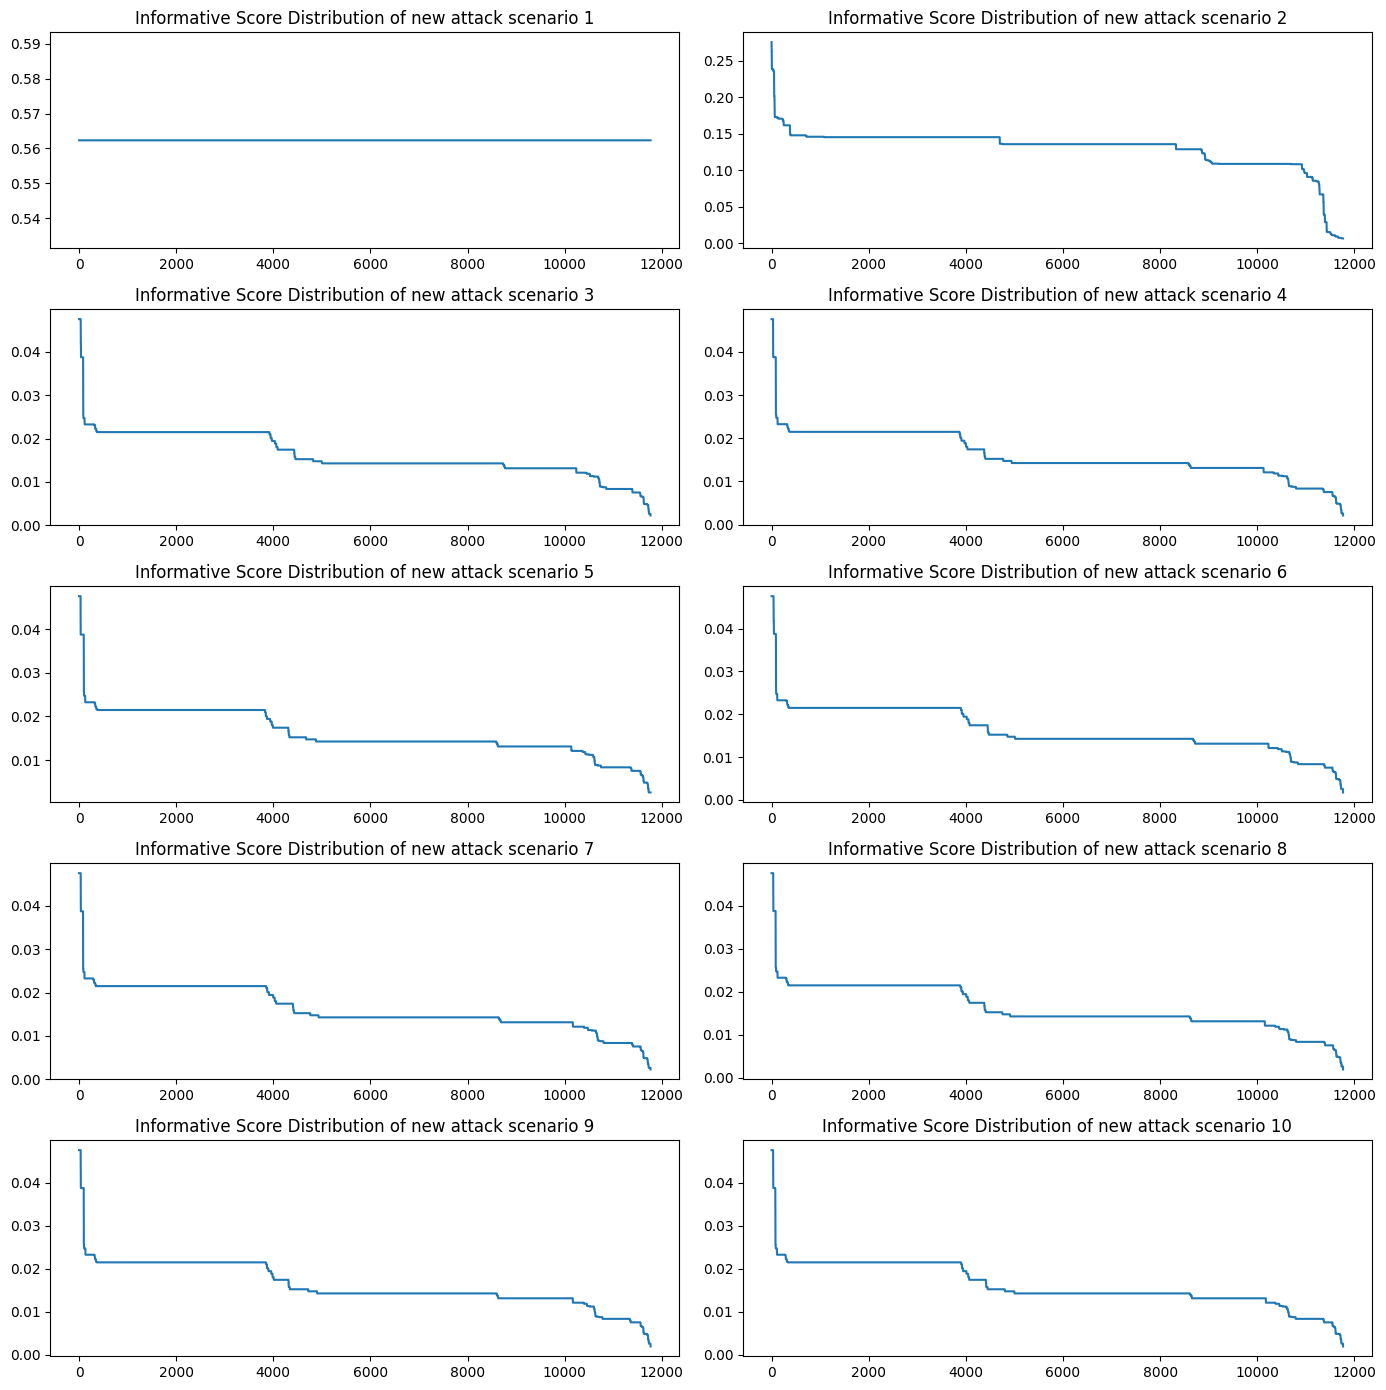

In [ ]:
def plot_supporting_scores(informative_score_list, n_times=10, sort=True):

    
    fig, axes = plt.subplots(n_times//2, 2, figsize=(14, 14))  # Create 5x2 subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(n_times):
      informative_arr = np.array(informative_score_list[i][:])
      if sort:
        informative_arr = -np.sort(-informative_arr)      
        axes[i].plot(np.arange(len(informative_arr)), informative_arr)
        axes[i].set_title(f"Informative Score Distribution of new attack scenario {i + 1}")

    plt.tight_layout()
    plt.show()
    
plot_supporting_scores(informative_score_list,10)

### New Data

Accuracy against new attack before training


In [ ]:
X_train_ge, X_test_ge, y_train_ge, y_test_ge = load_data(train_folder=["BENIGN/", "goldeneye/"])
counter = Counter(y_train_ge)
counter

['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeneye
dataset shape (237140, 61)
825 rows dropped
shape after removing nan: (236315, 61)
shape after dropping duplicates: (161282, 61)
False
True


Counter({0: 112065, 1: 16960})

In [ ]:
X_test_scaled_ge = scaler.transform(X_test_ge)
lm_out = lm.perform_inference(X_test_ge)
print("Accuracy of LM", accuracy_score(lm_out,y_test_ge),"F1_Score", f1_score(lm_out, y_test_ge))
gm_out = gm.perform_inference(X_test_ge
print("Accuracy of GM", accuracy_score(gm_out,y_test_ge), "F1_Score", f1_score(gm_out, y_test_ge)))

[0 1]
Accuracy of LM 0.8992466751402797


testing: 100%|██████████| 505/505 [00:06<00:00, 81.81it/s]

[0 1]
Accuracy of GM 0.8766779303717023


Train LM then GM (if LM doesn't improve train GM)

In [ ]:
gm_new = Global_Model(['dripper/', 'BENIGN/', 'bonesi/', 'training_data/gm/', 'goldeneye/']) #Reload the model


['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
['./Dataset/SimulatedCVE/cicflowmeter_cve/training_data/gm/gm_train_data_0.csv']
training_data/gm
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeneye
dataset shape (4

testing: 100%|██████████| 460/460 [00:05<00:00, 80.26it/s]

F1 Score: 0.8843, Accuracy: 0.9887
[[27810   205]
 [  128  1273]]


In [ ]:
lm = Local_Model(gm_new)
informative_score_list = lm.retrain_model(X_train_ge,threshold = 0.02,y_new=None, update_gm = False) # !Don't forget to change the update_gm flag

['lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']
['lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']
[0 0 0 ... 2 2 2]
Size of Label Index 20008
Round 0
[25390 26148 26147 ... 20339 23845 20260]
1599


testing: 100%|██████████| 25/25 [00:00<00:00, 84.67it/s]


[0 1]
New Label Counts: Counter({0: 1348, 1: 251})
Added 1599 Shape of Label_ind: (21607,)
Number of duplicates 0
np.unique: [0 1]
[0.01554626 0.01554626 0.01554626 0.02295572 0.02078914 0.01554626
 0.01554626 0.0054141  0.02693643 0.02078914 0.02078914 0.02078914
 0.02693643 0.02078914 0.02078914 0.01554626 0.02078914 0.02693643
 0.01554626 0.02078914 0.01263438 0.02693643 0.02693643 0.04754014
 0.01554626 0.02693643 0.01554626 0.02693643 0.01565134 0.02078914
 0.02078914 0.02693643 0.01224399 0.02693643 0.02693643 0.02078914
 0.01554626 0.02693643 0.01263438 0.00741874 0.02693643 0.01554626
 0.02693643 0.02693643 0.02078914 0.01554626 0.01767727 0.02078914
 0.02295572 0.02693643 0.02693643 0.01554626 0.01554626 0.02078914
 0.02078914 0.02693643 0.01554626 0.02693643 0.02693643 0.02078914
 0.01224399 0.02693643 0.02693643 0.02078914 0.02693643 0.01554626
 0.02693643 0.01614686 0.02693643 0.01554626 0.01554626 0.01507863
 0.02078914 0.01554626 0.02614074 0.01554626 0.02693643 0.0122439

testing: 100%|██████████| 22/22 [00:00<00:00, 80.83it/s]


[0 1]
New Label Counts: Counter({0: 1246, 1: 117})
Added 1363 Shape of Label_ind: (22970,)
Number of duplicates 0
np.unique: [0 1]
[0.00293297 0.00671602 0.00352876 0.00352876 0.00239346 0.00239346
 0.08418208 0.00352876 0.04291226 0.00341262 0.00352876 0.00352876
 0.00239346 0.00293297 0.00239346 0.08418208 0.04291226 0.08418208
 0.00293297 0.00239346 0.00293297 0.00352876 0.00293297 0.00293297
 0.00293297 0.00293297 0.00646156 0.08418208 0.00246056 0.00293297
 0.00352876 0.08276434 0.00352876 0.00285326 0.00293297 0.00293297
 0.00293297 0.00293297 0.00352876 0.08459564 0.00239346 0.00352876
 0.00352876 0.00293297 0.00352876 0.00293297 0.00239346 0.00352876
 0.00239346 0.00239346 0.00293297 0.00352876 0.00239346 0.00352876
 0.00293297 0.00352876 0.00352876 0.00352876 0.00293297 0.00239346
 0.00239346 0.00293297 0.00352876 0.00293297 0.00239346 0.04291226
 0.00239346 0.04291226 0.00317906 0.00293297 0.00352876 0.00246056
 0.00293297 0.00293297 0.00293297 0.00293297 0.08418208 0.0031977

testing: 100%|██████████| 20/20 [00:00<00:00, 86.97it/s]


[0 1]
New Label Counts: Counter({0: 1141, 1: 93})
Added 1234 Shape of Label_ind: (24204,)
Number of duplicates 0
np.unique: [0 1]
[0.00737316 0.00354248 0.02857119 0.02857119 0.02857119 0.01289162
 0.01632786 0.00737316 0.01632786 0.00721636 0.00721636 0.00215373
 0.01632786 0.01632786 0.013734   0.00354248 0.00354248 0.00354248
 0.00354248 0.00354248 0.01632786 0.01632786 0.00721636 0.01632786
 0.01632786 0.00354248 0.00354248 0.01632786 0.02724857 0.00354248
 0.01632786 0.01632786 0.01632786 0.00721636 0.00613201 0.00354248
 0.00721636 0.00328748 0.02724857 0.00354248 0.01632786 0.00613201
 0.01632786 0.00354248 0.01632786 0.00376623 0.01387728 0.00354248
 0.00354248 0.00354248 0.01632786 0.00354248 0.01632786 0.01632786
 0.01632786 0.02857119 0.01632786 0.00613201 0.00721636 0.01632786
 0.01632786 0.01632786 0.00354248 0.00354248 0.02857119 0.00319774
 0.00354248 0.00354248 0.00721636 0.00721636 0.01632786 0.01632786
 0.01632786 0.00354248 0.01632786 0.01632786 0.00637771 0.00354248

testing: 100%|██████████| 4/4 [00:00<00:00, 88.58it/s]

[0 1]
New Label Counts: Counter({1: 171, 0: 45})
Added 216 Shape of Label_ind: (24420,)
Number of duplicates 0
np.unique: [0 1]


[0.00364408 0.00474857 0.00364408 0.01079775 0.00474857 0.01184529
 0.00364408 0.01079775 0.00474857 0.00364408 0.00364408 0.01079775
 0.00474857 0.01079775 0.01079775 0.01184529 0.00698794 0.01079775
 0.01079775 0.01079775 0.01184529 0.00364408 0.00866314 0.01079775
 0.00364408 0.01079775 0.00364408 0.00364408 0.01079775 0.01079775
 0.01079775 0.00364408 0.00924545 0.00364408 0.00364408 0.01079775
 0.01671786 0.00364408 0.01079775 0.00364408 0.00364408 0.00290965
 0.00364408 0.00364408 0.01079775 0.00924545 0.00866314 0.00364408
 0.00364408 0.00364408 0.00364408 0.00364408 0.00474857 0.01079775
 0.01079775 0.01671786 0.00698794 0.00364408 0.01079775 0.00290965
 0.00474857 0.01671786 0.01794807 0.00364408 0.01079775 0.00364408
 0.00924545 0.01079775 0.00474857 0.00924545 0.01079775 0.00364408
 0.00364408 0.00364408 0.00364408 0.01079775 0.00364408 0.01671786
 0.00474857 0.01079775 0.00364408 0.01079775 0.00364408 0.01184529
 0.00698794 0.00189549 0.00364408 0.01079775 0.00589492 0.0107

testing: 100%|██████████| 68/68 [00:00<00:00, 80.32it/s]


[0 1]
New Label Counts: Counter({0: 4041, 1: 302})
Added 4343 Shape of Label_ind: (28763,)
Number of duplicates 0
np.unique: [0 1]
[0.01393642 0.0170546  0.0170546  0.01263485 0.02227042 0.12042169
 0.12042169 0.01857081 0.01857081 0.19029576 0.12042169 0.03081772
 0.02227042 0.16895992 0.02227042 0.02227042 0.01393642 0.11206656
 0.01823914 0.01823914 0.01717483 0.01393642 0.02227042 0.02650115
 0.02227042 0.01393642 0.02227042 0.01823914 0.0170546  0.02227042
 0.0170546  0.02227042 0.02908924 0.01857081 0.0170546  0.19029576
 0.02364554 0.01393642 0.18180293 0.0170546  0.0170546  0.0170546
 0.0170546  0.02227042 0.01393642 0.18180293 0.02227042 0.02227042
 0.01263485 0.02227042 0.0170546  0.0170546  0.02227042 0.18180293
 0.02227042 0.0170546  0.01393642 0.02227042 0.18180293 0.0170546
 0.01393642 0.12042169 0.01393642 0.18180293 0.02227042 0.02227042
 0.01326493 0.0170546  0.18180293 0.02227042 0.02227042 0.01393642
 0.02227042 0.01393642 0.0170546  0.0170546  0.12042169 0.18180293


testing: 100%|██████████| 50/50 [00:00<00:00, 81.17it/s]


[0 1]
New Label Counts: Counter({0: 2524, 1: 616})
Added 3140 Shape of Label_ind: (31903,)
Number of duplicates 0
np.unique: [0 1]
[0.00271841 0.00271841 0.04205395 0.00271841 0.09941961 0.22915757
 0.00191428 0.00271841 0.00191428 0.00271841 0.00271841 0.19365965
 0.19365965 0.22915757 0.10051566 0.00271841 0.19365965 0.0312143
 0.00271841 0.00329966 0.19365965 0.19365965 0.0312143  0.19365965
 0.09941961 0.00271841 0.00271841 0.00271841 0.19365965 0.09941961
 0.22915757 0.09941961 0.00271841 0.00271841 0.00271841 0.00271841
 0.22915757 0.00271841 0.25476834 0.09941961 0.00271841 0.19365965
 0.04205395 0.22915757 0.22915757 0.00329966 0.00271841 0.09310564
 0.00490813 0.10051566 0.00271841 0.22915757 0.09941961 0.19365965
 0.00271841 0.00312087 0.00271841 0.00271841 0.25476834 0.00271841
 0.22915757 0.22915757 0.22915757 0.22915757 0.01952466 0.19365965
 0.01143863 0.09993861 0.00191428 0.00271841 0.04475402 0.22915757
 0.22915757 0.00312087 0.19365965 0.0151774  0.00271841 0.22915757

testing: 100%|██████████| 46/46 [00:00<00:00, 79.29it/s]


[0 1]
New Label Counts: Counter({0: 2625, 1: 279})
Added 2904 Shape of Label_ind: (34807,)
Number of duplicates 0
np.unique: [0 1]
[0.01202142 0.00153027 0.00153027 0.00153027 0.00153027 0.00153027
 0.07794025 0.12867177 0.12867177 0.12867177 0.0705988  0.00153027
 0.12867177 0.00165943 0.00089657 0.12867177 0.00153027 0.00153027
 0.12867177 0.12867177 0.12180787 0.0705988  0.00153027 0.0705988
 0.0231129  0.12867177 0.02485594 0.00153027 0.00153027 0.12867177
 0.0705988  0.00165943 0.12867177 0.12732707 0.12867177 0.12867177
 0.01202142 0.12867177 0.12867177 0.00153027 0.00165943 0.00153027
 0.12867177 0.0012932  0.00153027 0.12867177 0.00153027 0.00153027
 0.00153027 0.00922689 0.00153027 0.00153027 0.12867177 0.07794025
 0.12867177 0.0705988  0.12867177 0.12867177 0.12867177 0.0705988
 0.12867177 0.0705988  0.00153027 0.00153027 0.02876057 0.12867177
 0.12867177 0.12867177 0.0705988  0.0705988  0.01202142 0.0103473
 0.0705988  0.00089657 0.12867177 0.12867177 0.00153027 0.12867177
 

testing: 100%|██████████| 28/28 [00:00<00:00, 82.03it/s]


[0 1]
New Label Counts: Counter({0: 1596, 1: 195})
Added 1791 Shape of Label_ind: (36598,)
Number of duplicates 0
np.unique: [0 1]
[0.00665002 0.00665002 0.23934714 0.37973842 0.00684664 0.00684664
 0.00684664 0.00684664 0.37973842 0.07327702 0.00684664 0.00684664
 0.37973842 0.01601951 0.00807798 0.00684664 0.02368734 0.02368734
 0.23934714 0.23934714 0.37973842 0.02095699 0.37973842 0.00665002
 0.37973842 0.23934714 0.07327702 0.00684664 0.23934714 0.37973842
 0.23934714 0.37973842 0.23934714 0.00684664 0.00684664 0.00684664
 0.24476546 0.23934714 0.37973842 0.23934714 0.00684664 0.00684664
 0.23934714 0.37973842 0.23934714 0.3739799  0.23934714 0.00485951
 0.00684664 0.00684664 0.00684664 0.24476546 0.00684664 0.00684664
 0.00684664 0.00665002 0.00684664 0.23934714 0.00684664 0.23934714
 0.37973842 0.05831861 0.23934714 0.23934714 0.07327702 0.37973842
 0.37973842 0.37973842 0.37973842 0.1309721  0.37973842 0.37973842
 0.37973842 0.00684664 0.23934714 0.00684664 0.37973842 0.0024581

testing: 100%|██████████| 44/44 [00:00<00:00, 87.02it/s]


[0 1]
New Label Counts: Counter({0: 2271, 1: 532})
Added 2803 Shape of Label_ind: (39401,)
Number of duplicates 0
np.unique: [0 1]
[0.06274112 0.11236884 0.10816707 0.00680098 0.00680098 0.10816707
 0.00680098 0.10816707 0.10816707 0.06529646 0.10816707 0.10816707
 0.00680098 0.10816707 0.10816707 0.10816707 0.06529646 0.10816707
 0.10816707 0.00680098 0.04216715 0.00680098 0.00680098 0.00680098
 0.06529646 0.00680098 0.00710246 0.00680098 0.00680098 0.06274112
 0.10816707 0.00680098 0.01230703 0.10816707 0.0123097  0.10816707
 0.06529646 0.10816707 0.06529646 0.06529646 0.00680098 0.00680098
 0.00680098 0.00388053 0.06529646 0.10816707 0.06529646 0.10816707
 0.01230703 0.00680098 0.10816707 0.08223887 0.01230703 0.10816707
 0.00680098 0.00680098 0.00680098 0.00680098 0.10816707 0.11236884
 0.00680098 0.00556761 0.01230703 0.0436628  0.09278578 0.10816707
 0.00680098 0.00680098 0.01230703 0.10816707 0.00680098 0.10816707
 0.00710246 0.10816707 0.10816707 0.00710246 0.00680098 0.0822388

testing: 100%|██████████| 74/74 [00:00<00:00, 83.39it/s]


[0 1]
New Label Counts: Counter({0: 3910, 1: 815})
Added 4725 Shape of Label_ind: (44126,)
Number of duplicates 0
np.unique: [0 1]
[0.00366473 0.02365759 0.01348559 0.04313897 0.01348559 0.02365759
 0.02147087 0.00064501 0.0340174  0.00366473 0.00064887 0.00142376
 0.01348559 0.00366473 0.02365759 0.02365759 0.01196932 0.01196932
 0.00366473 0.01348559 0.02365759 0.02365759 0.00366473 0.01348559
 0.00064501 0.02365759 0.01500269 0.00064887 0.02365759 0.00201678
 0.00064501 0.00366473 0.02365759 0.02365759 0.02365759 0.02365759
 0.02365759 0.00366473 0.02365759 0.01348559 0.00226408 0.02147087
 0.0093513  0.01434755 0.00064887 0.00366473 0.02365759 0.02365759
 0.01348559 0.00064501 0.02365759 0.01196932 0.00366473 0.00064501
 0.00064501 0.00366473 0.02365759 0.00366473 0.00366473 0.02365759
 0.00366473 0.02147087 0.00366473 0.00064501 0.02365759 0.00366473
 0.01348559 0.06917085 0.02365759 0.00366473 0.00366473 0.00366473
 0.00366473 0.02365759 0.01348559 0.02365759 0.01196932 0.0236575

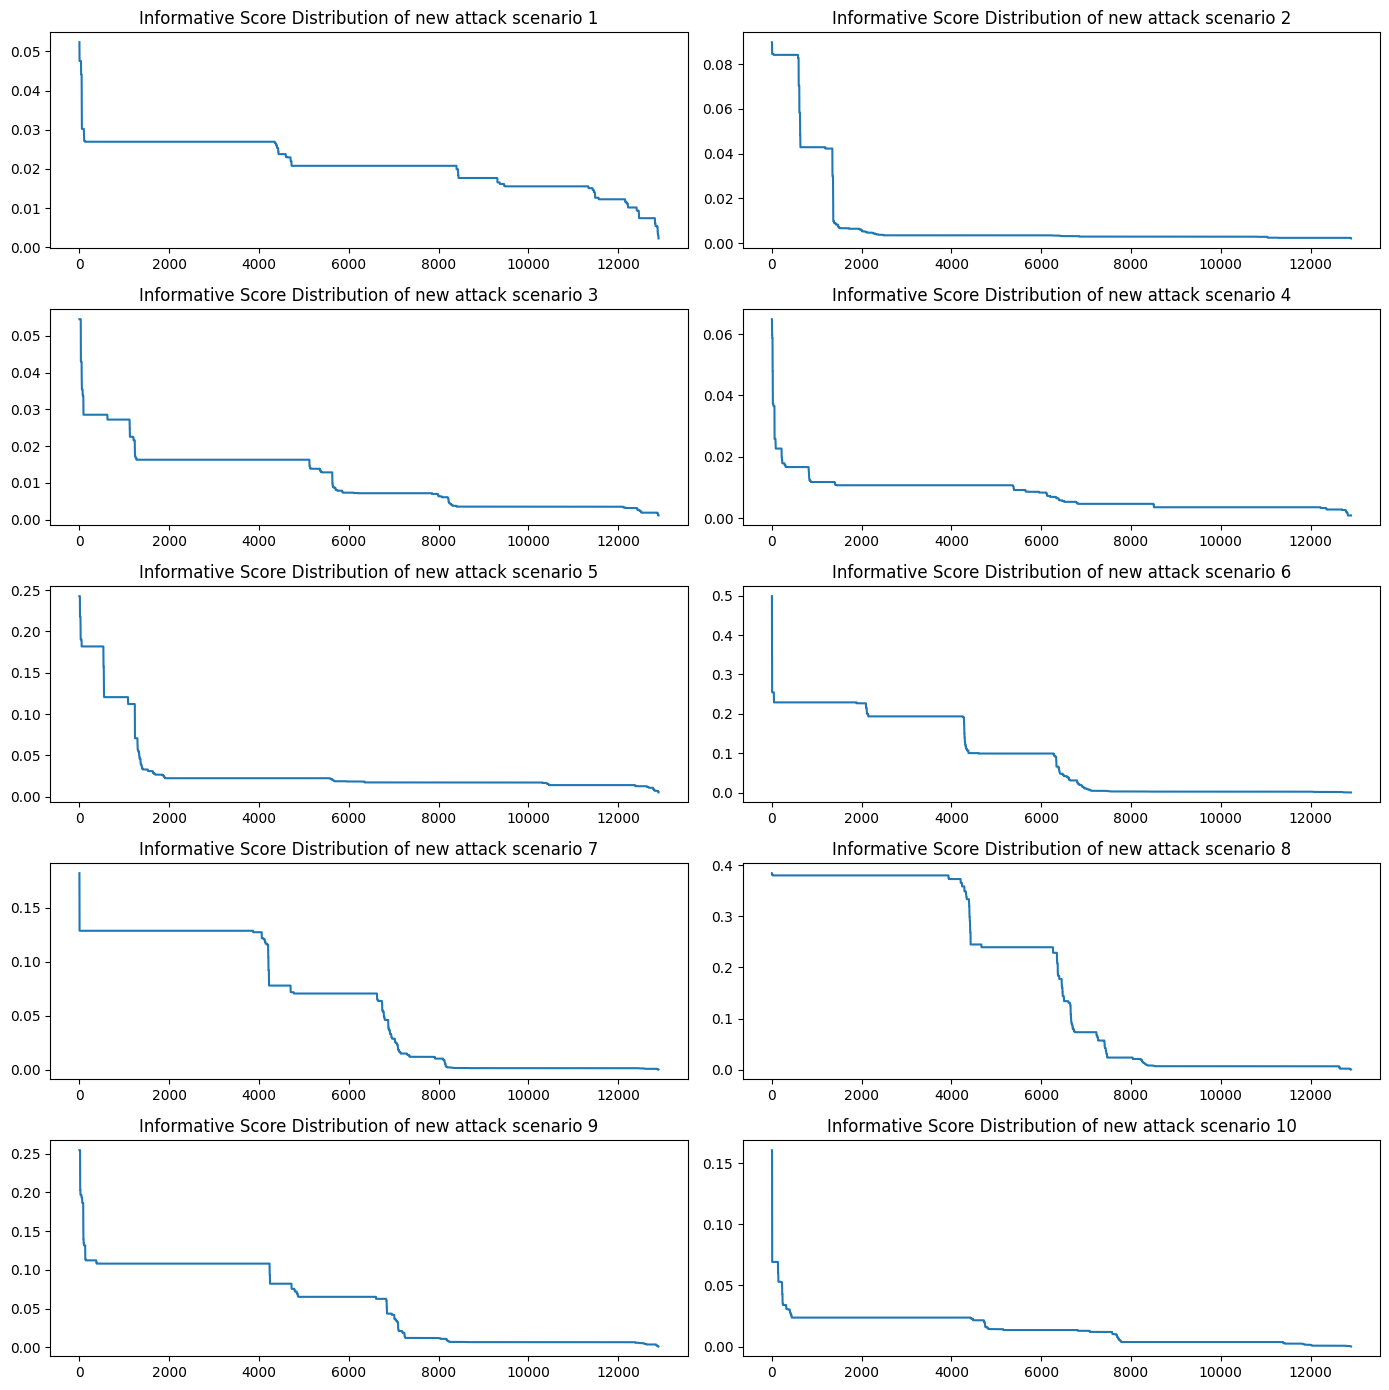

In [ ]:
plot_supporting_scores(informative_score_list,10)

In [ ]:
lm = Local_Model(gm_new)

['lm_train_data_3.csv', 'lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']


In [ ]:
lm_out = lm.perform_inference(X_test_ge)
print("Accuracy of LM", accuracy_score(lm_out,y_test_ge), "F1_Score", f1_score(lm_out, y_test_ge))
gm_out = gm_new.perform_inference(X_test_ge)
print("Accuracy of GM", accuracy_score(gm_out,y_test_ge), "F1_Score", f1_score(gm_out, y_test_ge))

[0 1]
Accuracy of LM 0.9666739002387079 F1_Score 0.8611290530939155


testing: 100%|██████████| 505/505 [00:06<00:00, 83.88it/s]

[0 1]
Accuracy of GM 0.9658678736398301 F1_Score 0.8584650983416892


## Globally Unseen Attack(GM Active Learning) State 4

### Giving the Complete Labeled Data

In [ ]:
def plot_anomaly_scores(anomaly_scores, y_test):
    # Separate anomaly scores based on the labels
    scores_inliers = anomaly_scores[y_test == 0]  # Assuming '0' is the label for inliers
    scores_outliers = anomaly_scores[y_test == 1]  # Assuming '1' is the label for outliers
    
    # Create the plots
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))  # Adjusted for better visualizati
    # Plot for inliers and outliers
    ax.hist(scores_inliers, bins=100, alpha=0.7, label='Inliers', log=True)
    ax.hist(scores_outliers, bins=100, alpha=0.7, label='Outliers', log=True)
    ax.set_title('Distribution of Anomaly Scores')
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Frequency')
    ax.legend()

In [ ]:
# ? Using the Original GM... 
# ? Since the GLobal Model offload 
gm_out = gm.perform_inference(X_test_ge)
print("Accuracy of Before Training GM", accuracy_score(gm_out,y_test), "F1_Score", f1_score(lm_out, y_test_ge))

['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeneye
dataset shape (237140, 61)
825 rows dropped
shape after removing nan: (236315, 61)
shape after dropping duplicates: (161282, 61)
False
True


testing: 100%|██████████| 505/505 [00:06<00:00, 82.84it/s]

[0 1]
Accuracy of Before Training GM 0.8770189416250737 F1_Score 0.8611290530939155


testing: 100%|██████████| 505/505 [00:06<00:00, 82.79it/s]


Optimal Threshold of gm 5.369312763214111


testing: 100%|██████████| 505/505 [00:06<00:00, 83.61it/s]


Optimal Threshold of gm_new 5.2912917137146


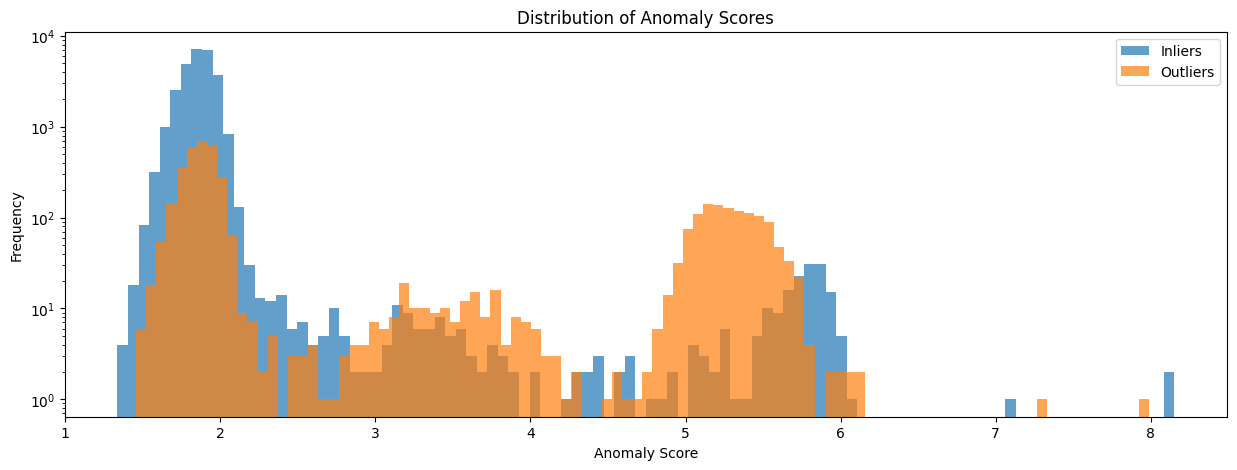

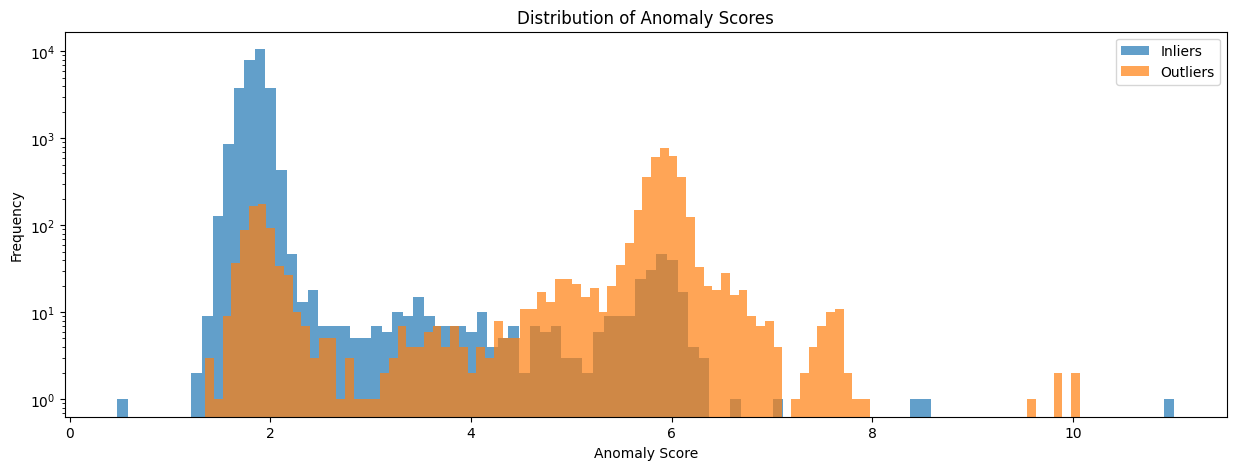

In [ ]:
X_test_scaled_ge = scaler.transform(X_test_ge)
anomaly_scores = gm.model.decision_function(X_test_scaled_ge)
print("Optimal Threshold of gm", gm.opt_threshold)
plot_anomaly_scores(anomaly_scores, y_test_ge)
new_anomaly_scores = gm_new.model.decision_function(X_test_scaled_ge)
print("Optimal Threshold of gm_new", gm_new.opt_threshold)
plot_anomaly_scores(new_anomaly_scores, y_test_ge)

### Training with GM's Active Learning and Unsupervised

Before

Take all the data

In [ ]:
# ge_df = pd.read_csv("Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv")
# ge_unlabeled_df = ge_df.copy()
# ge_unlabeled_df["Label"] = 0
# ge_unlabeled_df.to_csv("ge_unlabeled.csv", index=False)

In [ ]:
gm_ge = Global_Model(['dripper/', 'BENIGN/', 'bonesi/'], new_data_folder = ["goldeneye_unlabeled/"]) #Reload the model

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 61)
838 rows dropped
shape after removing nan: (403911, 61)
shape after dropping duplicates: (285190, 61)
False
True
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye_unlabeled/ge_unla

testing: 100%|██████████| 526/526 [00:06<00:00, 85.92it/s]

F1 Score: 0.9156, Accuracy: 0.9718
[[27557   458]
 [  491  5150]]


In [ ]:
gm_out = gm_ge.perform_inference(X_test_ge)
print("Accuracy of GM", accuracy_score(gm_out,y_test_ge), "F1_Score", f1_score(gm_out, y_test_ge))

testing: 100%|██████████| 505/505 [00:06<00:00, 82.87it/s]

[0 1]
Accuracy of GM 0.9754161887342282 F1_Score 0.90835548364729


testing: 100%|██████████| 505/505 [00:06<00:00, 81.59it/s]


Optimal Threshold of gm_new 5.2912917137146


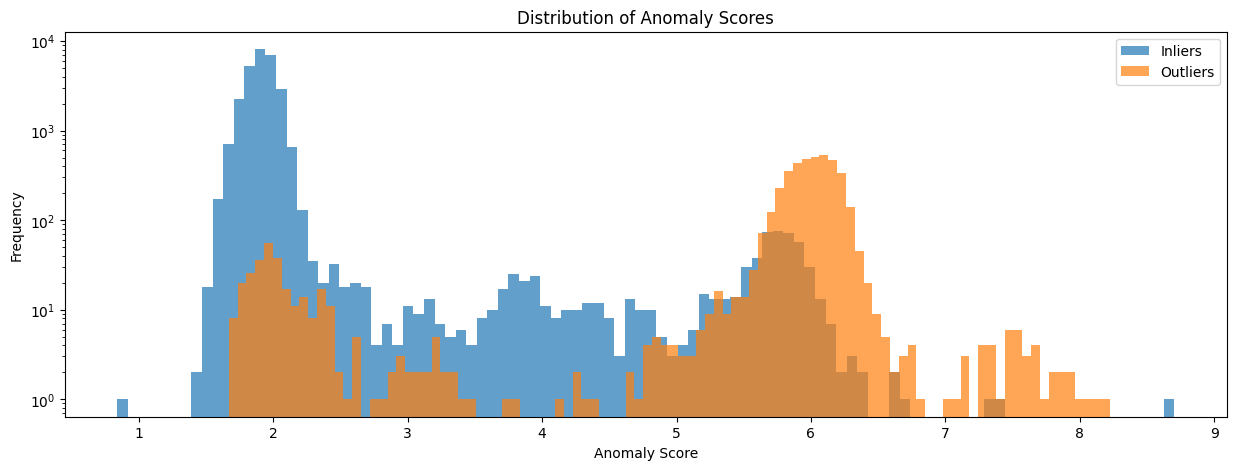

In [ ]:
X_test_scaled_ge = scaler.transform(X_test_ge)
new_anomaly_scores = gm_ge.model.decision_function(X_test_scaled_ge)
print("Optimal Threshold of gm_new", gm_new.opt_threshold)
plot_anomaly_scores(new_anomaly_scores, y_test_ge)

Take Data Near the Threshold
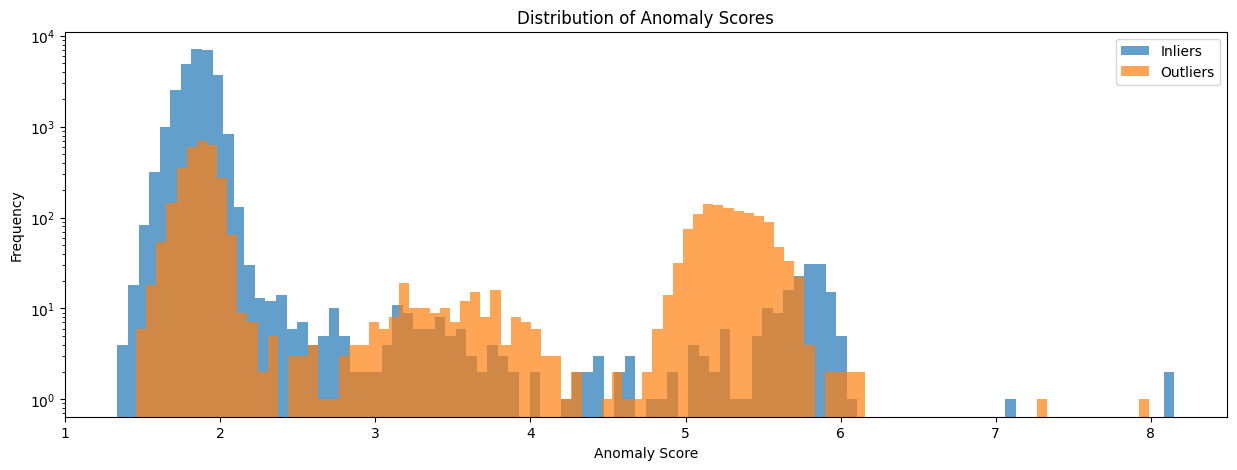

In [ ]:
ge_df = pd.read_csv("Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv")
ge_unlabeled_df = ge_df.copy()
ge_unlabeled_df["Label"] = 0

In [ ]:
def gm_select_data(gm, data):
  scaled_data = data[features[2:]]
  scaled_data = scaler.transform(scaled_data)
  scores = gm.model.decision_function(scaled_data)
  selected_idx = np.where(np.logical_and(scores > gm.opt_threshold -2, scores < gm.opt_threshold +1))
  return data.iloc[selected_idx]
# Using original GM, 
filtered_data = gm_select_data(gm,ge_unlabeled_df)
filtered_data.to_csv("goldeneye_filtered_0.csv", index=False)

testing: 100%|██████████| 333/333 [00:04<00:00, 78.80it/s]


In [ ]:
gm_filtered = Global_Model(['dripper/', 'BENIGN/', 'bonesi/'], new_data_folder = ["goldeneye_filtered/"]) #Reload the model

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 61)
838 rows dropped
shape after removing nan: (403911, 61)
shape after dropping duplicates: (285190, 61)
False
True
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye_filtered/goldeney

testing: 100%|██████████| 480/480 [00:05<00:00, 84.35it/s]

F1 Score: 0.9457, Accuracy: 0.9904
[[27825   191]
 [  105  2577]]


testing: 100%|██████████| 505/505 [00:05<00:00, 84.85it/s]


[0 1]
Accuracy of GM 0.975323185665127 F1_Score 0.9079981507165974


testing: 100%|██████████| 505/505 [00:06<00:00, 81.79it/s]


Optimal Threshold of gm_new 5.2912917137146


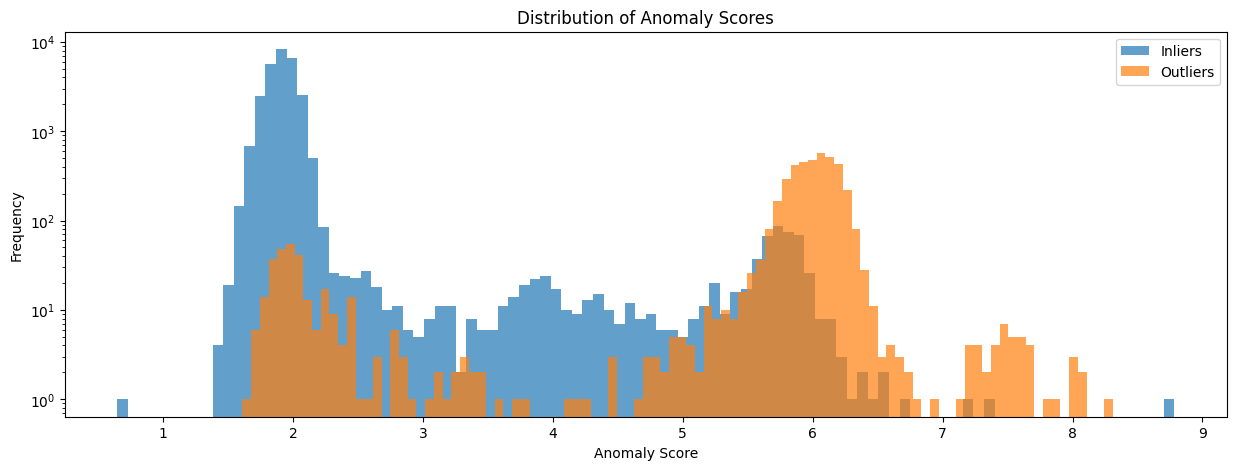

In [ ]:
gm_out = gm_ge.perform_inference(X_test_ge)
print("Accuracy of GM", accuracy_score(gm_out,y_test_ge), "F1_Score", f1_score(gm_out, y_test_ge))
X_test_scaled_ge = scaler.transform(X_test_ge)
new_anomaly_scores = gm_ge.model.decision_function(X_test_scaled_ge)
print("Optimal Threshold of gm_new", gm_new.opt_threshold)
plot_anomaly_scores(new_anomaly_scores, y_test_ge)

In [2]:
import pandas as pd

In [3]:
validated_flow_data = pd.read_csv("./x.csv")
validated_flow_data = validated_flow_data[validated_flow_data.columns[1:]]
validated_flow_data

,Dst IP,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.50.12,55122,8,10,0.0,76653.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,192.168.50.12,94824,19,14,0.0,141366.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,192.168.50.12,14879,18,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,192.168.50.12,71637,23,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,192.168.50.12,392404,71,35,0.0,166669.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,192.168.50.12,463017,56,33,381.0,239471.0,381.0,0.0,6.803571,50.913267,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
164,192.168.50.12,66199,11,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
165,192.168.50.12,75841,13,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
166,192.168.50.12,474968,51,36,381.0,239548.0,381.0,0.0,7.470588,53.350671,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
y = validated_flow_data["Label"]
X = validated_flow_data.drop(columns=["Label"], inplace=False)

In [5]:
selected_idx = y[y==1].sample(frac=1/3, random_state=42).index

In [6]:
y.to_csv("xx.csv")

In [48]:
X.drop(selected_idx,inplace=True)
y.drop(selected_idx,inplace=True)

In [49]:
X
y

,Src IP,Dst IP,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,192.168.50.181,192.168.50.12,6109181,13,7,386.0,16360.0,386.0,0.0,29.692308,...,1,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
1,192.168.50.181,192.168.50.12,6567271,13,6,325.0,16360.0,325.0,0.0,25.000000,...,1,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2,192.168.50.181,192.168.50.12,6563272,8,6,409.0,6269.0,409.0,0.0,51.125000,...,1,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
3,192.168.50.181,192.168.50.12,6567304,9,6,448.0,6269.0,448.0,0.0,49.777778,...,1,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
4,192.168.50.181,192.168.50.12,6564102,8,6,377.0,6260.0,377.0,0.0,47.125000,...,1,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21285,192.168.50.12,192.168.50.181,20170,1,1,0.0,0.0,0.0,0.0,0.000000,...,0,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
21286,192.168.50.181,192.168.50.12,32117925,4,2,0.0,0.0,0.0,0.0,0.000000,...,0,32,7678.0,0.0,7678.0,7678.0,15083409.5,2.184465e+04,15098856.0,15067963.0
21289,192.168.50.181,192.168.50.12,20960974,3,1,0.0,0.0,0.0,0.0,0.000000,...,0,32,3263.0,0.0,3263.0,3263.0,10478855.5,6.654342e+06,15184186.0,5773525.0
21290,192.168.50.12,192.168.50.181,187242,1,2,0.0,0.0,0.0,0.0,0.000000,...,0,32,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0


0        0
1        0
2        0
3        0
4        0
        ..
21285    1
21286    1
21289    1
21290    0
21293    0
Name: Label, Length: 19559, dtype: int64

KeyError: "None of [Index([13302, 13001, 20303, 20768, 19734, 18188,  6571, 13929, 14491, 14392,\n       ...\n       14539, 15422, 17542, 18483, 18859, 15939, 18619, 16094, 20651, 15098],\n      dtype='int64', length=1735)] are in the [index]"

In [6]:
# Loop through the packages and print their version
import pkg_resources
packages = [
    'numpy',
    'flask',
    'pandas',
    'joblib',
    'scikit-learn',
    'xgboost',
    'deepod',
    'flask',
    'joblib',
]

with open("requirements.txt", "w") as f:
    for package in packages:
        try:
            version = pkg_resources.get_distribution(package).version
            f.write(f"{package}=={version}\n")
            print(f"{package}=={version}")
        except pkg_resources.DistributionNotFound:
            print(f"{package} is not installed")


numpy==1.24.3
flask==3.0.3
pandas==2.0.3
joblib==1.4.0
scikit-learn==1.3.2
xgboost==2.1.1
deepod==0.4.1
flask==3.0.3
joblib==1.4.0


In [12]:
cleaned_df = read_csv(["bonesi"])

['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bones
dataset shape (35950, 61)
13 rows dropped
Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/U

In [11]:
cleaned_df.to_csv("DockerPreNet/Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/bonesi_data.csv")